# ACM in reduce dataset Setting

## Install Moabb 0.5

http://moabb.neurotechx.com/docs/index.html

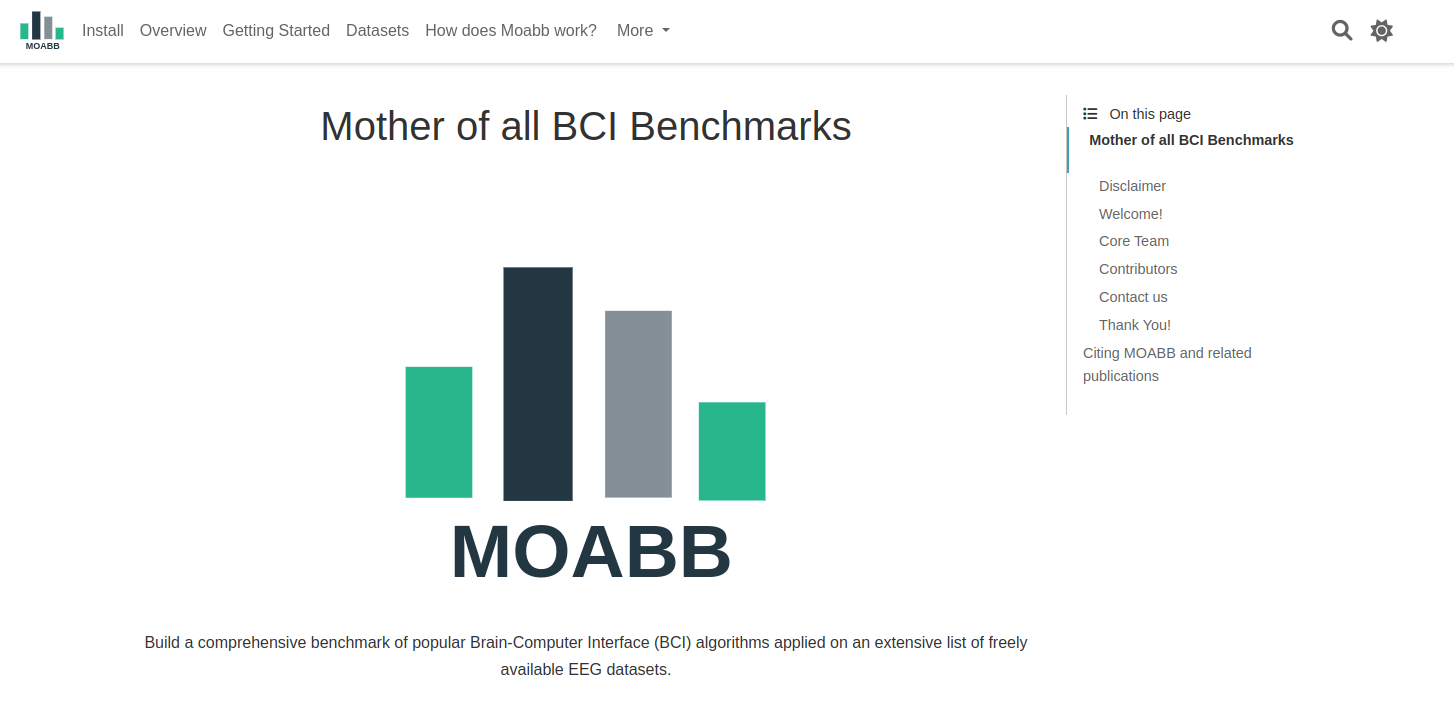

In [1]:
from IPython import display
display.Image("Image/Moabb_Release.png")

Key Features of MOABB 0.5:

- 📖 Enhanced Documentation: Our documentation has undergone significant improvements. We have added tutorials and examples to provide users with a seamless and user-friendly experience. Whether you're a beginner or an advanced user, you'll find the content well-organized and easy to follow.

- 📊 Efficient Grid Search: We have enhanced the compatibility of hyperparameter search with Grid Search during EEG Decoding. Now you can test a range of parameters and identify the optimal combination for your machine learning models.

- 🤖 Deep Learning State of the Art: We are thrilled to announce the implementation of state-of-the-art deep learning models using both PyTorch and TensorFlow back-ends, with particular attention to @BrainDecode library (https://lnkd.in/eS676QnK).

- 🔝 Machine Learning State of the Art: We have implemented and revised all machine learning models for various paradigms.

- 🌍 Code Carbon: In addition to performance metrics, we now introduce evaluation considering the carbon footprint produced by each model, since sustainable AI is our goal.

- 🆕 New Datasets: We have expanded the library's collection of datasets, including new P300 datasets and improvements to the existing ones.


In [2]:
!pip install moabb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
from datetime import datetime as dt
start = dt.now()

# Set up the Directory for made it run on a server.
import sys
import os
sys.path.append(r'/home/icarrara/Documents/Project/reduced_dataset')  # Local
# sys.path.append(r'/home/icarrara/Documents/Project/autoregressive_bci')  # Server

import moabb
import mne
new_path = '/home/icarrara/Documents/Project/autoregressive_bci/Data'  # Local
# new_path = '/home/icarrara/Documents/Project/autoregressive_bci/Data'  # Server
moabb.utils.set_download_dir(new_path)

import resource
from moabb.paradigms import MotorImagery
from moabb.datasets import BNCI2014001
from sklearn.preprocessing import LabelEncoder
from pyriemann.estimation import Covariances
from Feature_Extraction.Vectorize import Vectorize
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from moabb.evaluations import WithinSessionEvaluation
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from pyriemann.tangentspace import TangentSpace
from ar_models.Augmented_Dataset import AugmentedDataset
from pyriemann.spatialfilters import CSP
from pyriemann.classification import MDM
import pandas as pd
from pyriemann.classification import FgMDM

from ar_models.MOABB_Plot import (
    plot_results_compute_dataset_statistics,
    plot_results_compute_dataset_statistics2,
    score_plot,
    barplot_tot
)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import moabb.analysis.plotting as moabb_plt
from moabb.analysis.meta_analysis import (
    collapse_session_scores,
    compute_dataset_statistics,
    find_significant_differences,
)

2023-06-06 18:50:49.181962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing

In the following we load the computation for subject 1 on BNCI2014001:
- Bandpass filter [8, 35]Hz
- 4 seconds epoch
- Right Hand vs Left Hand
- Selection of only 3 electrodes on Motor Cortex

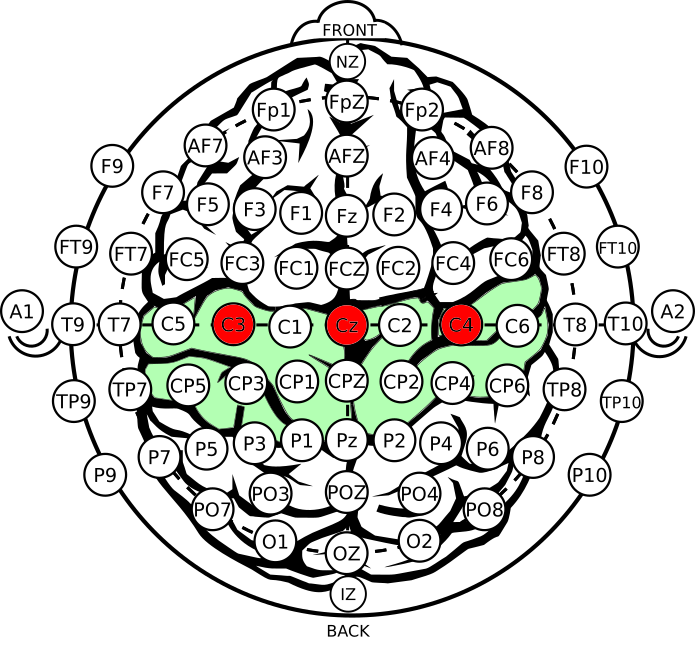

In [4]:
display.Image("Image/Electrodes.png")

In [5]:
# Initialize parameter for the Band Pass filter
fmin = 8
fmax = 35
tmin = 0
tmax = None

# Select the Subject
# Load the dataset, right now you have added Nothing events to DATA using new stim channel STI
dataset = BNCI2014001()

events = ["right_hand", "left_hand"]

paradigm = MotorImagery(events=events, n_classes=len(events), fmin=fmin, 
                        fmax=fmax, tmax=tmax, channels=["C3", "C4", "Cz"])

# Create a path and folder for every subject
path = os.path.join(str("STATE_ART_1"))
os.makedirs(path, exist_ok=True)

## Pipelines and Hyperparameter

In [6]:
# Pipelines
pipelines = {}
# Define the different algorithm to test and assign a name in the dictionary
pipelines["Vectorize+LDA"] = Pipeline(steps=[
    ("Covariances", Covariances("cov")),
    ("Vectorize", Vectorize()),
    ("lda", LDA(solver="lsqr", shrinkage="auto"))
])

pipelines["AUG+Vectorize+LDA"] = Pipeline(steps=[
    ("augmenteddataset", AugmentedDataset(order=5, lag=3)),
    ("Covariances", Covariances("cov")),
    ("Vectorize", Vectorize()),
    ("lda", LDA(solver="lsqr", shrinkage="auto"))
])

pipelines["AUG+TGSP+SVM"] = Pipeline(steps=[
    ("augmenteddataset", AugmentedDataset(order=5, lag=3)),
    ("Covariances", Covariances("cov")),
    ("Tangent_Space", TangentSpace(metric="riemann")),
    ("SVM", SVC(kernel="rbf"))
])

pipelines["MDM"] = Pipeline(steps=[
    ("Covariances", Covariances("cov")),
    ("MDM", MDM(metric=dict(mean='riemann', distance='riemann')))
])

pipelines["Cov+EN"] = Pipeline(steps=[
    ("Covariances", Covariances("cov")),
    ("Tangent_Space", TangentSpace(metric="riemann")),
    ("LogistReg", LogisticRegression(penalty="elasticnet", l1_ratio=0.15, intercept_scaling=1000.0, solver="saga"))
])

pipelines["FgMDM"] = Pipeline(steps=[
    ("Covariances", Covariances("cov")),
    ("FgMDM", FgMDM(metric=dict(mean='riemann', distance='riemann')))
])

pipelines["CSP+LDA"] = Pipeline(steps=[
    ("Covariances", Covariances("cov")),
    ("csp", CSP(nfilter=3)),
    ("lda", LDA(solver="lsqr", shrinkage="auto"))
])

pipelines["AUG+CSP+LDA"] = Pipeline(steps=[
    ("augmenteddataset", AugmentedDataset(order=5, lag=3)),
    ("Covariances", Covariances("cov")),
    ("csp", CSP(nfilter=3)),
    ("lda", LDA(solver="lsqr", shrinkage="auto"))
])

In [7]:
# GridSearch
param_grid = {}
param_grid["Cov+EN"] = {
    'LogistReg__l1_ratio': [0.15, 0.30, 0.45, 0.60, 0.75],
}

param_grid["AUG+Vectorize+LDA"] = {
    'augmenteddataset__order': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'augmenteddataset__lag': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

param_grid["AUG+TGSP+SVM"] = {
    'augmenteddataset__order': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'augmenteddataset__lag': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'SVM__C': [0.5, 1, 1.5],
    'SVM__kernel': ["linear", "rbf"],
}

param_grid["AUG+CSP+LDA"] = {
    'augmenteddataset__order': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'augmenteddataset__lag': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

## Evaluation on 1 subject

In [8]:
# Evaluation For MOABB
dataset.subject_list = [1]
evaluation = WithinSessionEvaluation(paradigm=paradigm,
                                     datasets=dataset,
                                     overwrite=False,
                                     random_state=42,
                                     hdf5_path=path,
                                     n_jobs=-1)

# Print the results
result = evaluation.process(pipelines, param_grid)

001-2014-WithinSession: 100%|█████████████████████| 1/1 [00:00<00:00, 31.86it/s]


## Analysis of the results

In [9]:
path = "../classification_3ch/MOABB_lhrh/BNCI2014001"
score = "score_test"
results1 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_1/results.cvs"))
results2 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_2/results.cvs"))
results3 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_3/results.cvs"))
results4 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_4/results.cvs"))
results5 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_5/results.cvs"))
results6 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_6/results.cvs"))
results7 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_7/results.cvs"))
results8 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_8/results.cvs"))
results9 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_9/results.cvs"))
frames = [results1, results2, results3, results4, results5, results6, results7, results8, results9]
results_ALL_ = pd.concat(frames)

path1 = os.path.join(path, "Results/")
os.makedirs(path1, exist_ok=True)

results_ALL = results_ALL_.rename(columns={score: "score"})

# Save the framework for all dataset in a CVS
results_ALL.to_csv(os.path.join(path, "Results/results.cvs"))

# Compute Statistics
stats_ALL = compute_dataset_statistics(results_ALL)
stats_ALL.to_csv(os.path.join(path, "Results/statistic.cvs"))

# Compute summary statistics
results_pipeline = results_ALL.groupby(['pipeline'], as_index=False)["score"].mean()
results_pipeline_std = results_ALL.groupby(['pipeline'], as_index=False)["score"].std()
results_pipeline['std'] = results_pipeline_std["score"]
results_pipeline.to_csv(os.path.join(path, "Results/statistic_summary.cvs"))

# Create Folder
path2 = os.path.join(path, "Figure/")
os.makedirs(path2, exist_ok=True)

display.display(results_pipeline)

,pipeline,score,std
0,AUG+CSP+LDA,0.829089,0.122511
1,AUG+TGSP+SVM,0.863896,0.099971
2,AUG+Vectorize+LDA,0.818934,0.114091
3,CSP+LDA,0.765839,0.155792
4,Cov+EN,0.777014,0.145912
5,FgMDM,0.770722,0.148802
6,MDM,0.754562,0.151973
7,Vectorize+LDA,0.732098,0.145582


## Visualization

### Bar Plot

In [10]:
order_list = ["MDM",
              "Cov+EN",
              "FgMDM",
              "Vectorize+LDA",
              "AUG+Vectorize+LDA",
              "CSP+LDA",
              "AUG+CSP+LDA",
              "AUG+TGSP+SVM"]

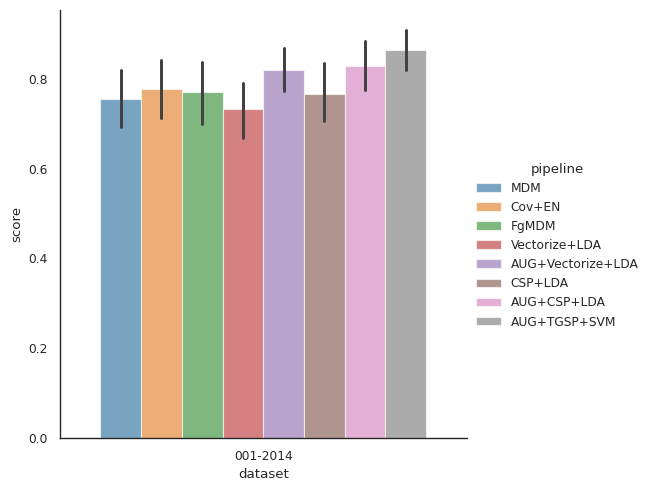

In [11]:
# Bar Plot TOTAl
sns.set_theme(context="paper", style="white", font_scale=1, palette="tab10")
barplot_tot(results_ALL,
            filename=os.path.join(path, "Figure/Paper/score_plot3"),
            order_list=order_list,
            score="score"
            )

### Statistical Analysis

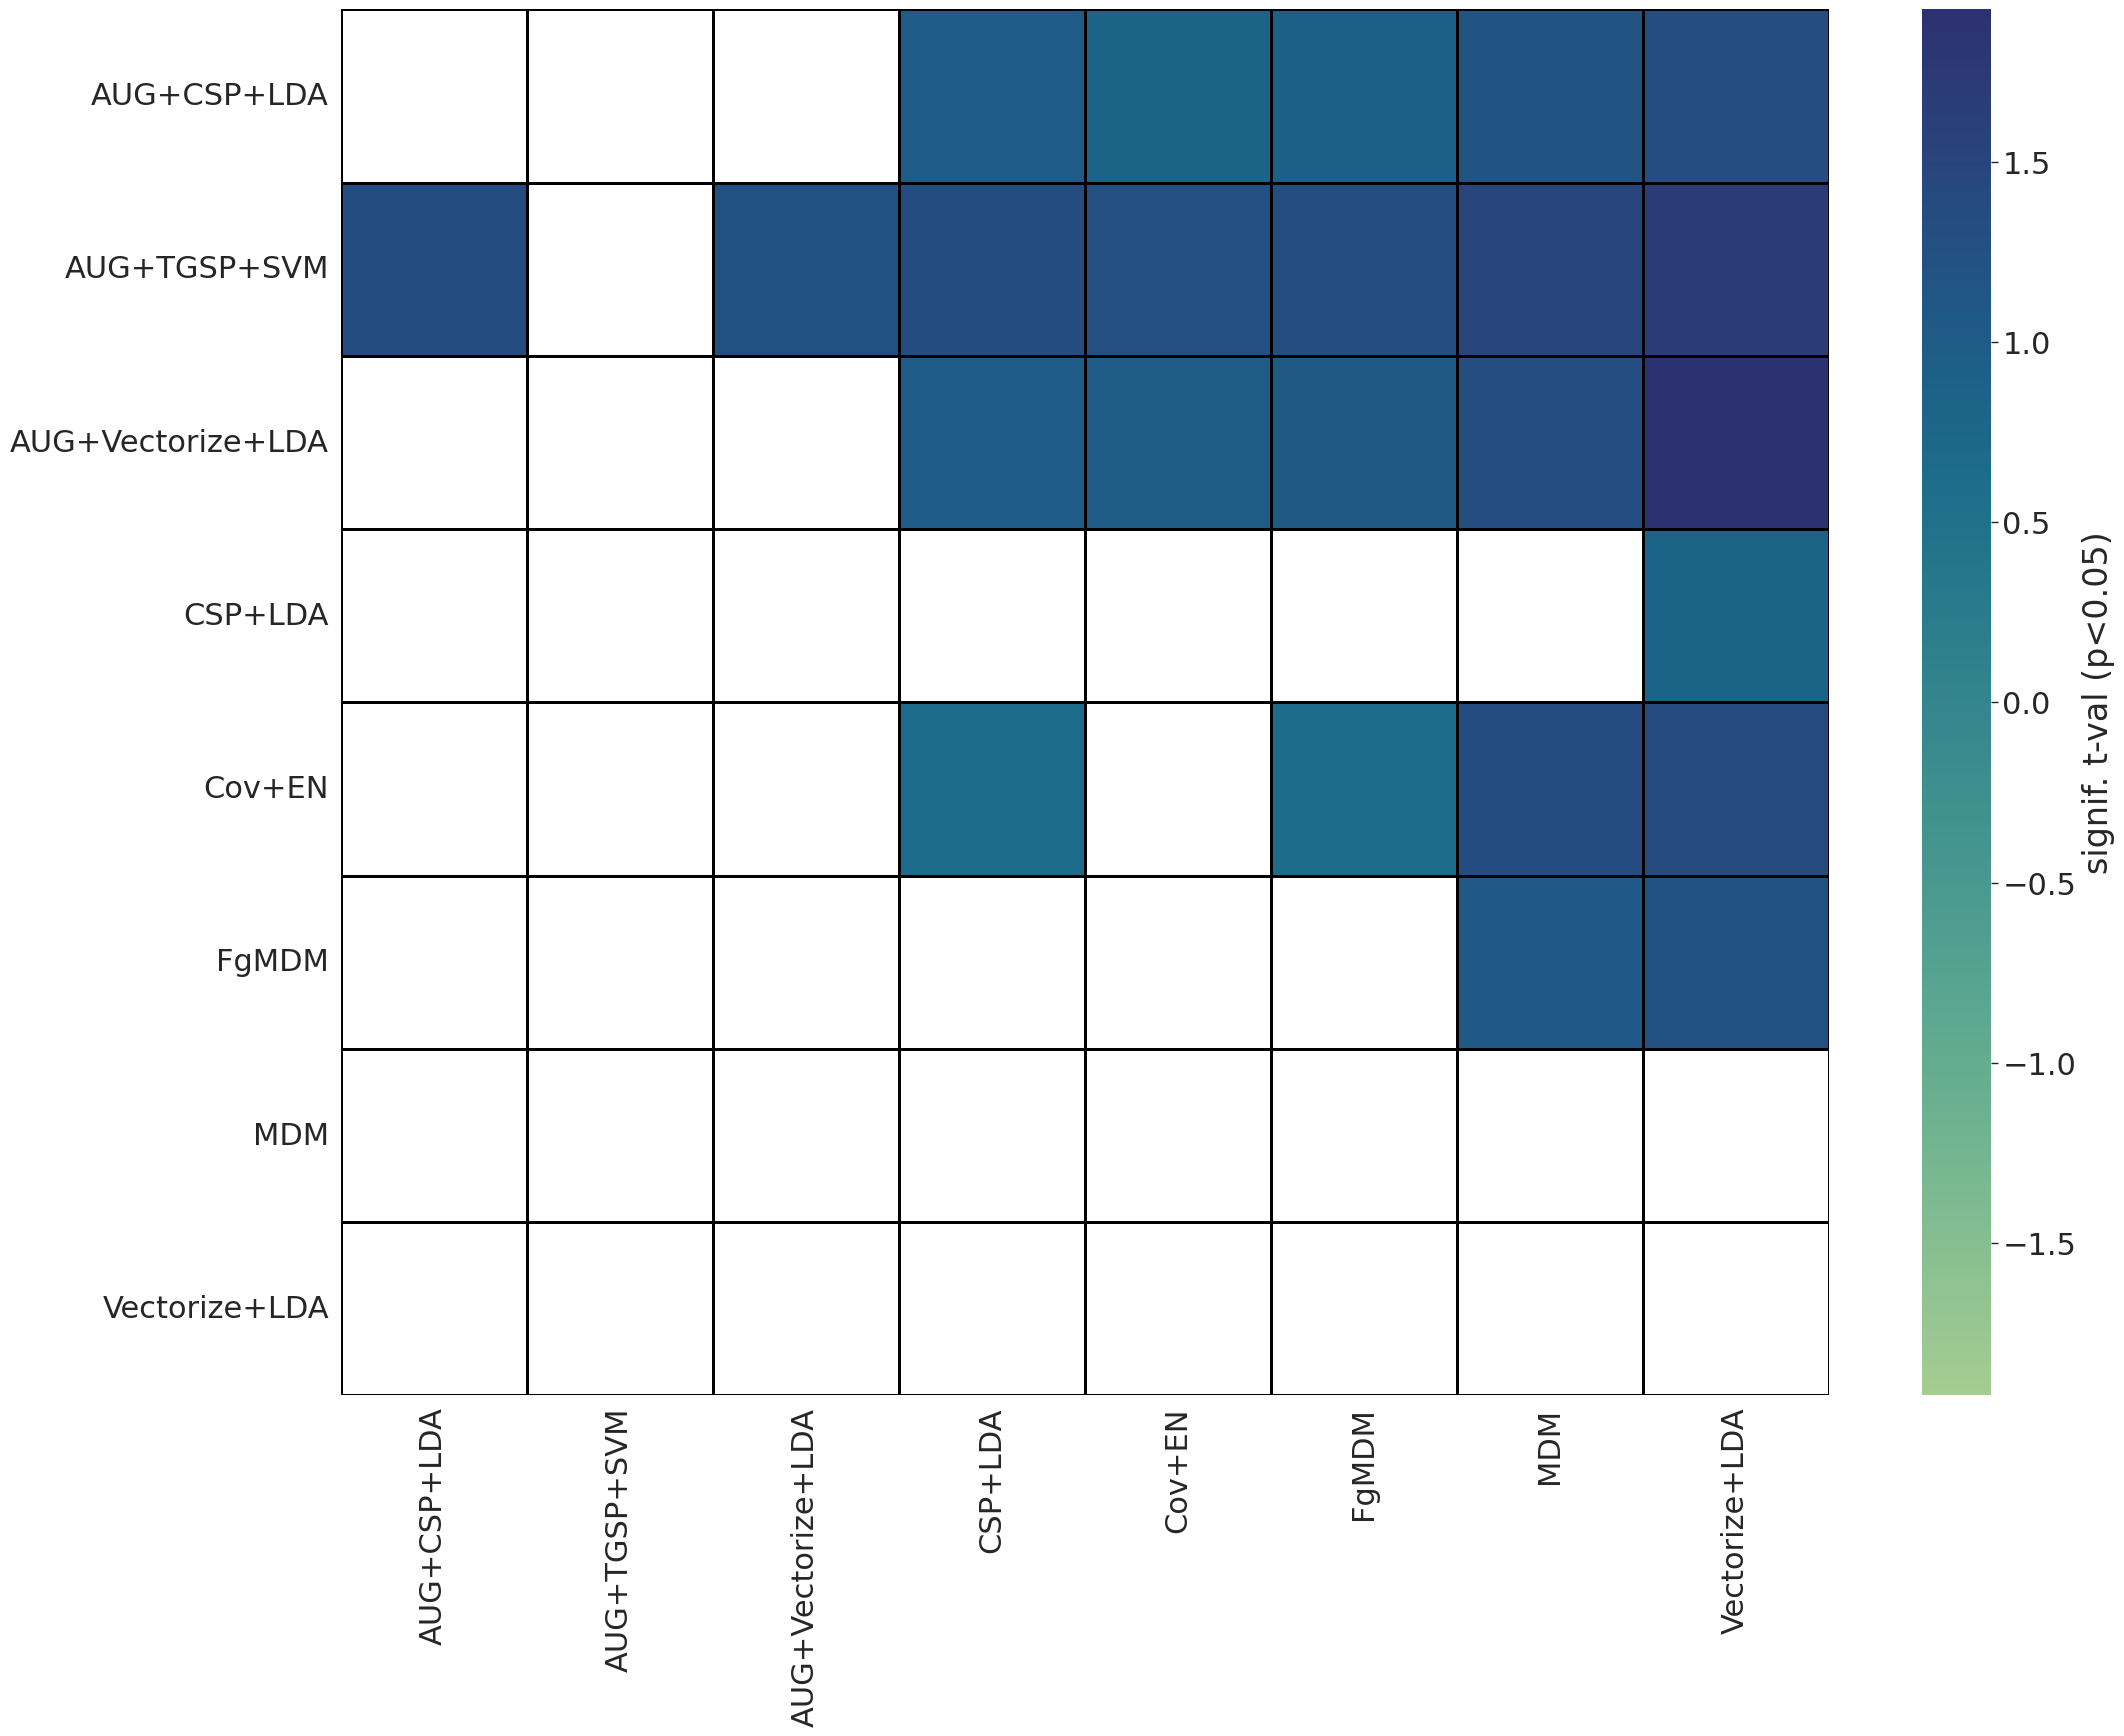

In [12]:
# plot dataset statistics2
sns.set_theme(context="paper", style="white", font_scale=2.5, palette="tab10")
plot_results_compute_dataset_statistics(stats_ALL, os.path.join(path, "Figure/Paper/dataset_statistics"), annotation=False)

### Meta Analysis

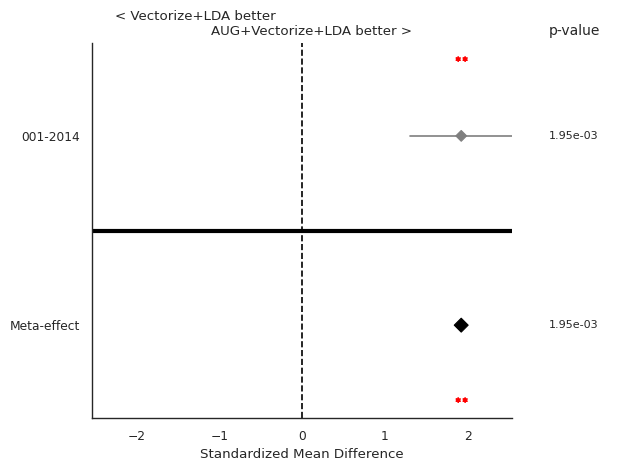

In [13]:
# Meta analysis plot
sns.set_theme(context="paper", style="white", font_scale=1, palette="tab10")
fig = moabb_plt.meta_analysis_plot(stats_ALL, "AUG+Vectorize+LDA", "Vectorize+LDA")
plt.savefig(os.path.join(path, "Figure/Paper/meta_plot_VectLDA.pdf"), dpi=300)

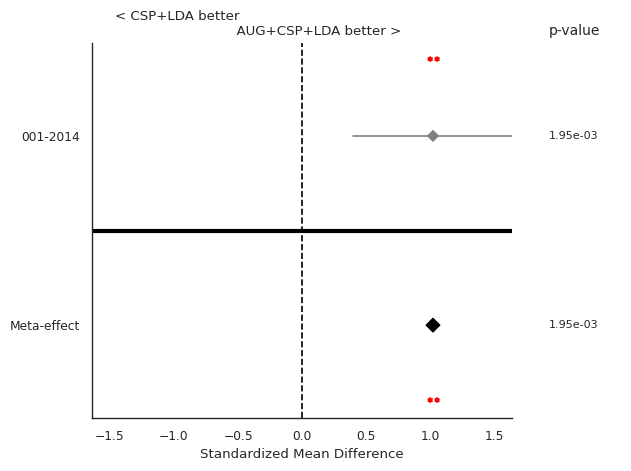

In [14]:
# Meta analysis plot
fig = moabb_plt.meta_analysis_plot(stats_ALL, "AUG+CSP+LDA", "CSP+LDA")
plt.savefig(os.path.join(path, "Figure/Paper/meta_plot_CSPLDA.pdf"), dpi=300)

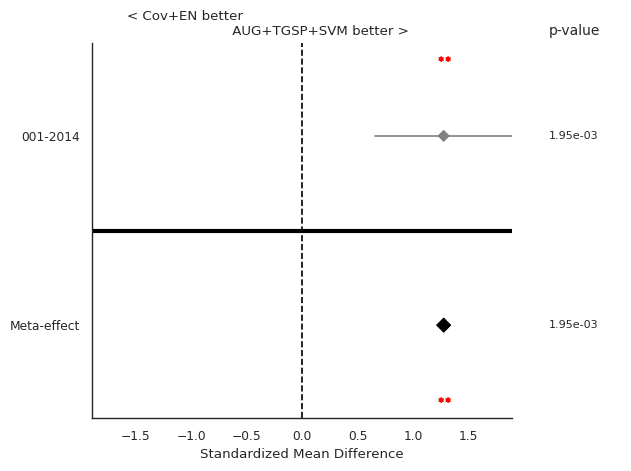

In [15]:
# Meta analysis plot
fig = moabb_plt.meta_analysis_plot(stats_ALL, "AUG+TGSP+SVM", "Cov+EN")
plt.savefig(os.path.join(path, "Figure/Paper/meta_plot_CovEN.pdf"), dpi=300)

## Analysis Full vs 3 Electrodes

In [18]:
path = "../classification_Full/MOABB_lhrh/BNCI2014001"
score = "score_test"
results1 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_1/results.cvs"))
results2 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_2/results.cvs"))
results3 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_3/results.cvs"))
results4 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_4/results.cvs"))
results5 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_5/results.cvs"))
results6 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_6/results.cvs"))
results7 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_7/results.cvs"))
results8 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_8/results.cvs"))
results9 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_9/results.cvs"))
frames = [results1, results2, results3, results4, results5, results6, results7, results8, results9]
results_ = pd.concat(frames)

results_Full = results_[(results_["pipeline"] == "Cov+EN") |
                        (results_["pipeline"] == "FgMDM") |
                        (results_["pipeline"] == "CSP+LDA") |
                        (results_["pipeline"] == "ACM+TGSP+SVM")
                        ]

path = "../classification_3ch/MOABB_lhrh/BNCI2014001"
results1 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_1/results.cvs"))
results2 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_2/results.cvs"))
results3 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_3/results.cvs"))
results4 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_4/results.cvs"))
results5 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_5/results.cvs"))
results6 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_6/results.cvs"))
results7 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_7/results.cvs"))
results8 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_8/results.cvs"))
results9 = pd.read_csv(os.path.join(path, "STATE_ART_Subject_9/results.cvs"))
frames = [results1, results2, results3, results4, results5, results6, results7, results8, results9]
results_ = pd.concat(frames)

results_3Elect = results_[(results_["pipeline"] == "Cov+EN") |
                          (results_["pipeline"] == "FgMDM") |
                          (results_["pipeline"] == "CSP+LDA") |
                          (results_["pipeline"] == "AUG+TGSP+SVM")]

results_3Elect = results_3Elect.replace({"Cov+EN": "Cov+EN(3 elect)",
                                         "FgMDM": "FgMDM(3 elect)",
                                         "CSP+LDA": "CSP+LDA(3 elect)",
                                         "AUG+TGSP+SVM": "ACM+TGSP+SVM(3 elect)"})


frames = [results_Full, results_3Elect]
results_ALL_ = pd.concat(frames)

path1 = os.path.join(path, "Results/")
os.makedirs(path1, exist_ok=True)

results_ALL = results_ALL_.rename(columns={score: "score"})

print(path)

# Save the framework for all dataset in a CVS
results_ALL.to_csv(os.path.join(path, "Results/results_Full.cvs"))

# Compute Statistics
stats_ALL = compute_dataset_statistics(results_ALL)
stats_ALL.to_csv(os.path.join(path, "Results/statistic_Full.cvs"))

# Compute summary statistics
results_pipeline = results_ALL.groupby(['pipeline'], as_index=False)["score"].mean()
results_pipeline_std = results_ALL.groupby(['pipeline'], as_index=False)["score"].std()
results_pipeline['std'] = results_pipeline_std["score"]
results_pipeline.to_csv(os.path.join(path, "Results/statistic_summary_Full.cvs"))

# Create Folder
path2 = os.path.join(path, "Figure/")
os.makedirs(path2, exist_ok=True)

display.display(results_pipeline)

../classification_3ch/MOABB_lhrh/BNCI2014001


,pipeline,score,std
0,ACM+TGSP+SVM,0.946720,0.073388
1,ACM+TGSP+SVM(3 elect),0.863896,0.099971
2,CSP+LDA,0.859210,0.131735
3,CSP+LDA(3 elect),0.765839,0.155792
4,Cov+EN,0.885276,0.110587
5,Cov+EN(3 elect),0.777014,0.145912
6,FgMDM,0.877230,0.113853
7,FgMDM(3 elect),0.770722,0.148802


## Visualization

### Bar Plot

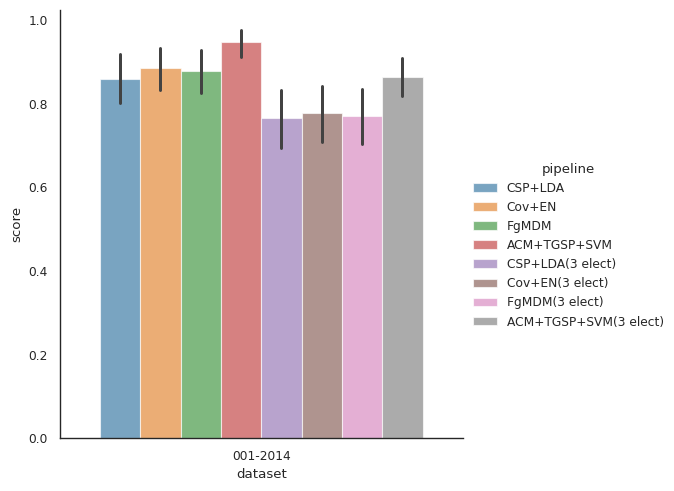

In [19]:
order_list = ["CSP+LDA",
              "Cov+EN",
              "FgMDM",
              "ACM+TGSP+SVM",
              "CSP+LDA(3 elect)",
              "Cov+EN(3 elect)",
              "FgMDM(3 elect)",
              "ACM+TGSP+SVM(3 elect)"]

# Bar Plot TOTAl
sns.set_theme(context="paper", style="white", font_scale=1, palette="tab10")
barplot_tot(results_ALL,
            filename=os.path.join(path, "Figure/Paper/Full/score_plot3"),
            order_list=order_list
            )

### Statistical Analysis

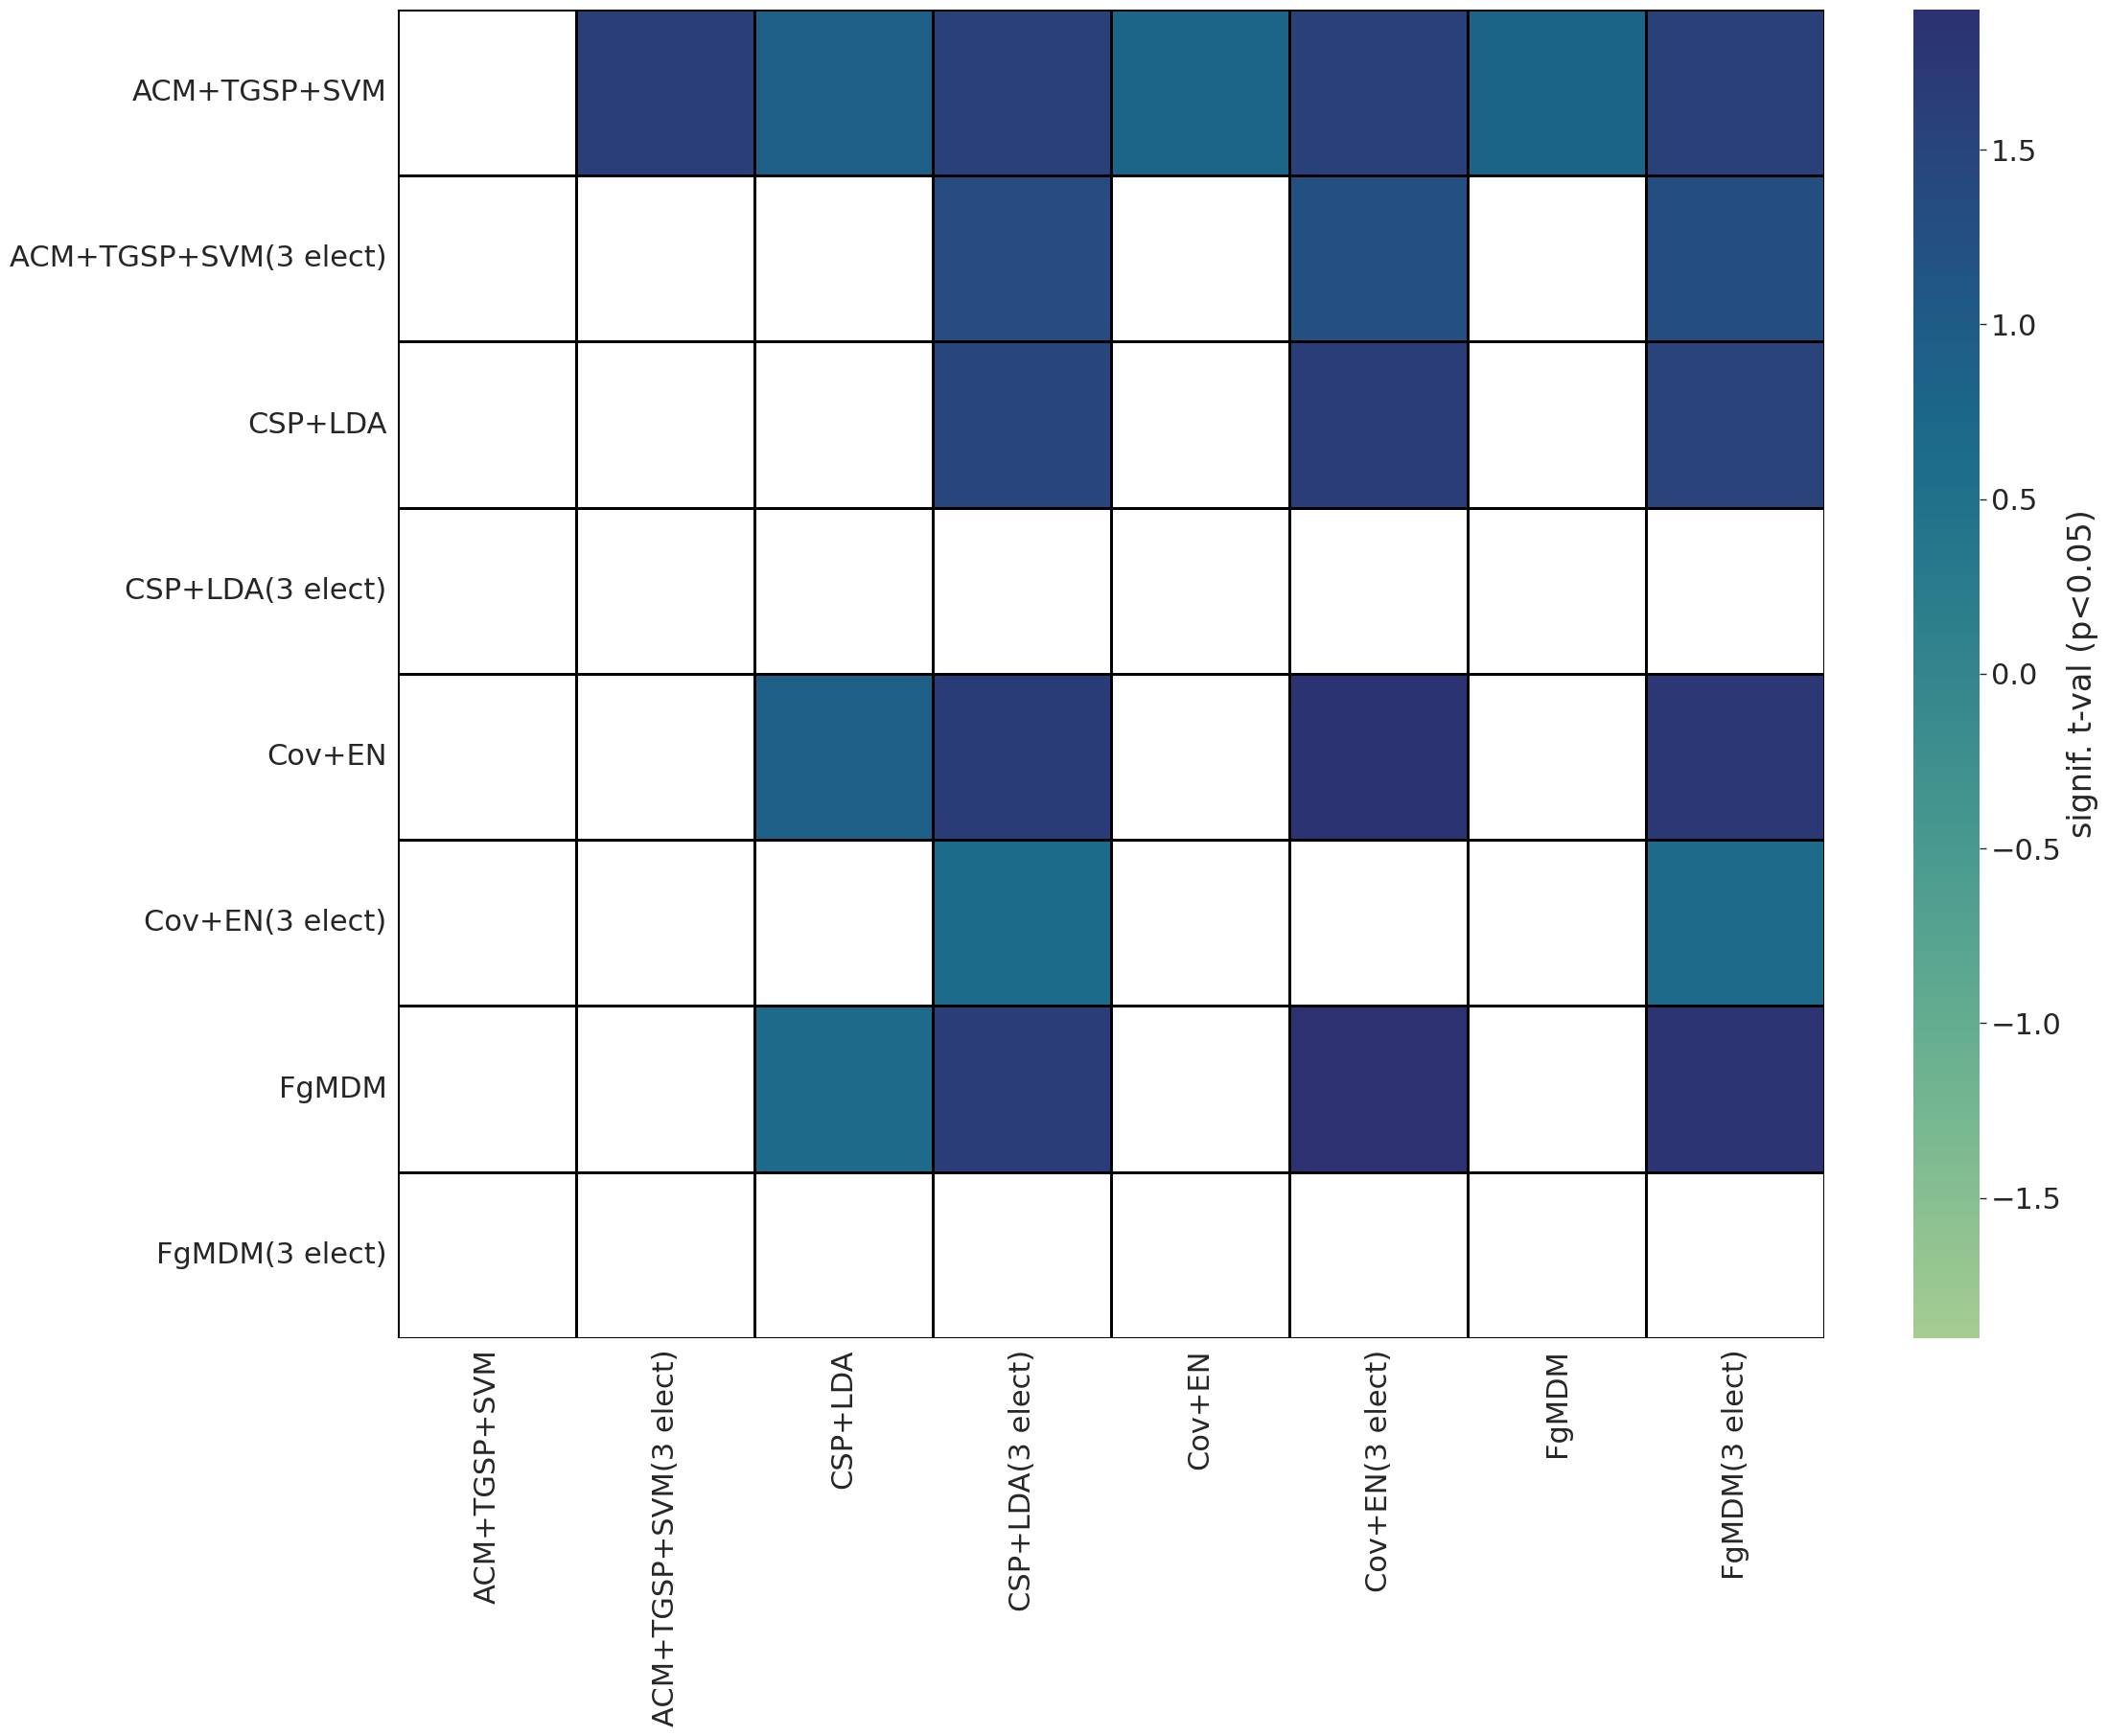

In [20]:
# plot dataset statistics2
sns.set_theme(context="paper", style="white", font_scale=2.5, palette="tab10")
plot_results_compute_dataset_statistics(stats_ALL, os.path.join(path, "Figure/Paper/Full/dataset_statistics"), annotation=False)

### Meta Plot

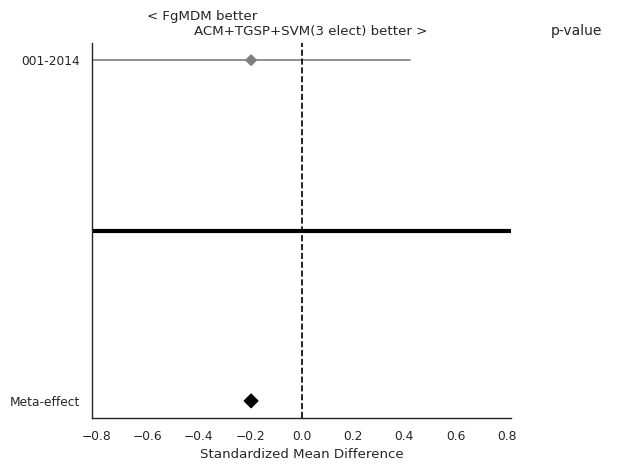

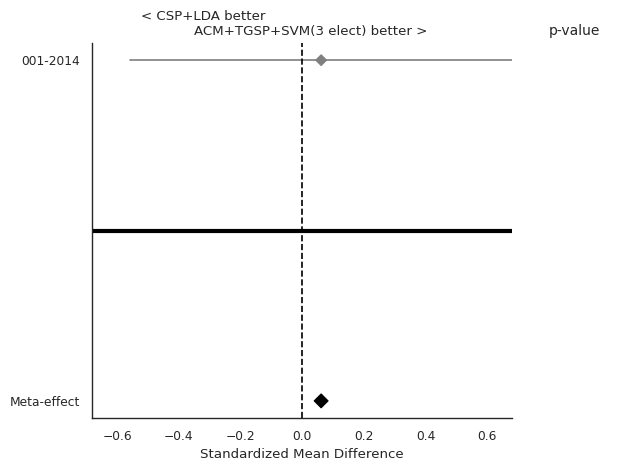

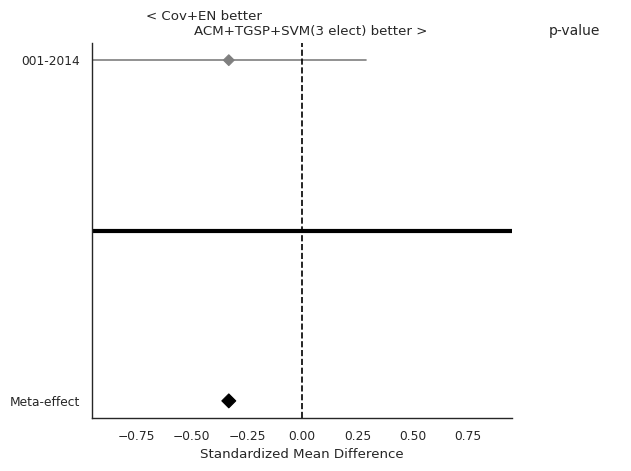

In [21]:
sns.set_theme(context="paper", style="white", font_scale=1, palette="Pastel2")
# Meta analysis plot
fig = moabb_plt.meta_analysis_plot(stats_ALL, "ACM+TGSP+SVM(3 elect)", "FgMDM")
plt.savefig(os.path.join(path, "Figure/Paper/Full/meta_plot_FgMDM.pdf"), dpi=300)

# Meta analysis plot
fig = moabb_plt.meta_analysis_plot(stats_ALL, "ACM+TGSP+SVM(3 elect)", "CSP+LDA")
plt.savefig(os.path.join(path, "Figure/Paper/Full/meta_plot_CSPLDA.pdf"), dpi=300)

# Meta analysis plot
fig = moabb_plt.meta_analysis_plot(stats_ALL, "ACM+TGSP+SVM(3 elect)", "Cov+EN")
plt.savefig(os.path.join(path, "Figure/Paper/Full/meta_plot_CovEN.pdf"), dpi=300)